In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from matplotlib.patches import Rectangle
from scipy.sparse import csr_matrix
from skimage.transform import rescale
from skimage.morphology import disk
from condition_numbers import best_conds, conds

def paralleltomo(N, theta=None, p=None, d=None):
    """
    PARALLELTOMO Creates a 2D tomography system matrix using parallel beams
    
      [A,theta,p,d] = paralleltomo(N)
      [A,theta,p,d] = paralleltomo(N,theta)
      [A,theta,p,d] = paralleltomo(N,theta,p)
      [A,theta,p,d] = paralleltomo(N,theta,p,d)
    
    This function creates a 2D tomography test problem with an N-times-N
    domain, using p parallel rays for each angle in the vector theta.
    
    Input: 
      N           Scalar denoting the number of discretization intervals in 
                  each dimesion, such that the domain consists of N^2 cells.
      theta       Vector containing the angles in degrees. Default: theta = 
                  0:1:179.
      p           Number of parallel rays for each angle. Default: p =
                  round(sqrt(2)*N).
      d           Scalar denoting the distance from the first ray to the last.
                  Default: d = sqrt(2)*N.
    
    Output:
      A           Coefficient matrix with N^2 columns and nA*p rows, 
                  where nA is the number of angles, i.e., length(theta).
      theta       Vector containing the used angles in degrees.
      p           The number of used rays for each angle.
      d           The distance between the first and the last ray.
    
    See also: fanbeamtomo, seismictomo.

    Anders Nymark Christensen, 20180216, DTU Compute

    Revised from the matlab version by:    
    Jakob Sauer Jørgensen, Maria Saxild-Hansen and Per Christian Hansen,
    October 1, 201r, DTU Compute.

    Reference: A. C. Kak and M. Slaney, Principles of Computerized 
    Tomographic Imaging, SIAM, Philadelphia, 2001.
    """

    # Default value of the angles theta.
    if theta is None:
        theta = np.matrix(np.arange(0.,180.))

    # Default value of the number of rays.
    if p is None:
        p = int(round(np.sqrt(2)*N))

    # Default value of d.
    if d is None:
        d = np.sqrt(2)*N

    # Define the number of angles.
    nA = theta.shape[1]

    # The starting values both the x and the y coordinates. 
    x0 = np.matrix(np.linspace(-d/2,d/2,p)).T
    y0 = np.matrix(np.zeros([p,1]))

    # The intersection lines.
    x = np.matrix(np.arange(-N/2,N/2 + 1)).T
    y = np.copy(x)

    # Initialize vectors that contains the row numbers, the column numbers and
    # the values for creating the matrix A effiecently.
    rows = np.matrix(np.zeros([2*N*nA*p,1]))
    cols = np.copy(rows)
    vals = np.copy(rows)
    idxend = 0

    # Loop over the chosen angles.
    for i in range(0,nA):
                
        # All the starting points for the current angle.
        x0theta = np.cos(np.deg2rad(theta[0,i]))*x0-np.sin(np.deg2rad(theta[0,i]))*y0
        y0theta = np.sin(np.deg2rad(theta[0,i]))*x0+np.cos(np.deg2rad(theta[0,i]))*y0
        
        # The direction vector for all the rays corresponding to the current 
        # angle.
        a = -np.sin(np.deg2rad(theta[0,i]))
        b = np.cos(np.deg2rad(theta[0,i]))
        
        # Loop over the rays.
        for j in range(0,p):
            # Use the parametrisation of line to get the y-coordinates of
            # intersections with x = k, i.e. x constant.
            tx = (x - x0theta[j,0])/a
            yx = b*tx + y0theta[j,0]
            
            # Use the parametrisation of line to get the x-coordinates of
            # intersections with y = k, i.e. y constant.
            ty = (y - y0theta[j,0])/b
            xy = a*ty + x0theta[j,0]            
            
            # Collect the intersection times and coordinates. 
            t = np.vstack([tx, ty])
            xxy = np.vstack([x, xy])
            yxy = np.vstack([yx, y])
            
            # Sort the coordinates according to intersection time.
            I = np.argsort(t,0)
            xxy = xxy[I]
            yxy = yxy[I]        
            
            # Skip the points outside the box.
            I1 = np.logical_and(np.array(xxy) >= -N/2 , np.array(xxy) <= N/2)
            I2 = np.logical_and(np.array(yxy) >= -N/2 , np.array(yxy) <= N/2)
            I = np.squeeze(np.logical_and(I1,I2))
            #I = (xxy >= -N/2 & xxy <= N/2 & yxy >= -N/2 & yxy <= N/2)
            xxy = np.squeeze(xxy[I])
            yxy = np.squeeze(yxy[I])
            
            # Skip double points.
            I = np.logical_and(abs(np.diff(xxy)) <= 1e-10 , abs(np.diff(yxy)) <= 1e-10)
            if np.not_equal(I.size, 0):
                I = np.concatenate((I, np.matrix([False])), axis=1)
            xxy = xxy[~I]
            yxy = yxy[~I]
            #xxy = np.delete(xxy,I)
            #yxy = np.delete(yxy,I)
            
            # Calculate the length within cell and determines the number of
            # cells which is hit.
            d = np.sqrt(np.power(np.diff(xxy),2) + np.power(np.diff(yxy),2))
            numvals = d.shape[1]
            
            # Store the values inside the box.
            if numvals > 0:
                
                # If the ray is on the boundary of the box in the top or to the
                # right the ray does not by definition lie with in a valid cell.
                if not ((b == 0 and abs(y0theta[j,0] - N/2) < 1e-15) or (a == 0 and abs(x0theta[j,0] - N/2) < 1e-15)):
                    
                    # Calculates the midpoints of the line within the cells.
                    xm = 0.5*(xxy[0,0:-1]+xxy[0,1:]) + N/2
                    ym = 0.5*(yxy[0,0:-1]+yxy[0,1:]) + N/2
                    
                    # Translate the midpoint coordinates to index.
                    col = np.floor(xm)*N + (N - np.floor(ym)) - 1
                    
                    # Create the indices to store the values to vector for
                    # later creation of A matrix.
                    idxstart = idxend
                    idxend = idxstart + numvals
                    idx = np.arange(idxstart,idxend)
                    
                    # Store row numbers, column numbers and values. 
                    rows[idx,0] = i*p + j
                    cols[idx,0] = col[0,:]
                    vals[idx,0] = d

                    if np.min(cols[:,0]) < 0:
                        garbage = 1 + 1

    # Truncate excess zeros.
    rows = rows[0:idxend]
    cols = cols[0:idxend]
    vals = vals[0:idxend]
    
    # Create sparse matrix A from the stored values.
    A = csr_matrix((vals[:,0].astype(float), (np.squeeze(np.array(rows[:,0]).astype(int)), np.squeeze(np.array(cols[:,0]).astype(int)))), dtype=float, shape=(p*nA, N**2)).toarray()

    return (A, theta, p, d)

def reconstruct_image(im, theta=None, p=None, d=None, noise_scale=None):
    N = im.shape[0]
    x = im.flatten()
    (A, _, _, _) = paralleltomo(N, np.matrix(theta), p, d)
    b = A @ x

    if noise_scale is not None:
        b += noise_scale * np.random.poisson(b)

    x_rec = np.linalg.lstsq(A, b, rcond=None)[0]
    im_rec = x_rec.reshape(N, N)

    return im_rec

def scale_image(im, scale):
    return rescale(im, scale, anti_aliasing=False)

def generate_image(r_log, r_bullets, mu_wood, mu_iron, mu_bis):
    im = disk(r_log) * mu_wood
    N = 2*r_log

    for r_bullet in r_bullets:
        im_mask_iron = disk(r_bullet, dtype=bool)
        im_mask_bis = disk(r_bullet, dtype=bool)

        x_iron = np.random.randint(N)
        y_iron = np.random.randint(N)

        x_bis = np.random.randint(N)
        y_bis = np.random.randint(N)

        is_iron_in_log = np.sqrt((x_iron - r_log)**2 + (y_iron - r_log)**2) < r_log - r_bullet
        is_bis_in_log = np.sqrt((x_bis - r_log)**2 + (y_bis - r_log)**2) < r_log - r_bullet

        while not is_iron_in_log:
            x_iron = np.random.randint(N)
            y_iron = np.random.randint(N)
            is_iron_in_log = np.sqrt((x_iron - r_log)**2 + (y_iron - r_log)**2) < r_log - r_bullet

        while not is_bis_in_log:
            x_bis = np.random.randint(N)
            y_bis = np.random.randint(N)
            is_bis_in_log = np.sqrt((x_bis - r_log)**2 + (y_bis - r_log)**2) < r_log - r_bullet

        im[x_iron-r_bullet-1:x_iron+r_bullet, y_iron-r_bullet-1:y_iron+r_bullet][im_mask_iron] = mu_iron
        im[x_bis-r_bullet-1:x_bis+r_bullet, y_bis-r_bullet-1:y_bis+r_bullet][im_mask_bis] = mu_bis

    return im[0:N, 0:N]

def detect_bullets(im, mu_iron, mu_bis, rel_error_iron, rel_error_bis, im_scale=1):
    abs_error_iron = rel_error_iron * mu_iron
    abs_error_bis = rel_error_bis * mu_bis

    im_mask_iron = np.logical_and(
        (mu_iron - abs_error_iron) / im_scale <= im, 
        im <= (mu_iron + abs_error_iron) / im_scale
    )
    im_mask_bis = np.logical_and(
        (mu_bis - abs_error_bis) / im_scale <= im, 
        im <= (mu_bis + abs_error_bis) / im_scale
    )

    n = im_mask_iron.shape[0]
    boxes_iron = []
    boxes_bis = []

    for x in range(n):
        for y in range(n):
            if im_mask_iron[x, y]:
                queue = []
                xs = []
                ys = []

                queue.append((x,y))
                xs.append(x)
                ys.append(y)
                im_mask_iron[x, y] = False

                while len(queue) > 0:
                    (x, y) = queue.pop()

                    if x+1 < n and im_mask_iron[x+1, y]:
                        queue.append((x+1,y))
                        xs.append(x+1)
                        ys.append(y)
                        im_mask_iron[x+1, y] = False

                    if y+1 < n and im_mask_iron[x, y+1]:
                        queue.append((x,y+1))
                        xs.append(x)
                        ys.append(y+1)
                        im_mask_iron[x, y+1] = False
                    
                    if x-1 >= 0 and im_mask_iron[x-1, y]:
                        queue.append((x-1,y))
                        xs.append(x-1)
                        ys.append(y)
                        im_mask_iron[x-1, y] = False

                    if y-1 >= 0 and im_mask_iron[x, y-1]:
                        queue.append((x,y-1))
                        xs.append(x)
                        ys.append(y-1)
                        im_mask_iron[x, y-1] = False
                
                boxes_iron.append(((min(xs), min(ys)), (max(xs), max(ys)), len(xs)))
            
            if im_mask_bis[x, y]:
                queue = []
                xs = []
                ys = []

                queue.append((x,y))
                xs.append(x)
                ys.append(y)
                im_mask_bis[x, y] = False

                while queue:
                    (x, y) = queue.pop()

                    if x+1 < n and im_mask_bis[x+1, y]:
                        queue.append((x+1,y))
                        xs.append(x+1)
                        ys.append(y)
                        im_mask_bis[x+1, y] = False

                    if y+1 < n and im_mask_bis[x, y+1]:
                        queue.append((x,y+1))
                        xs.append(x)
                        ys.append(y+1)
                        im_mask_bis[x, y+1] = False

                    if x-1 >= 0 and im_mask_bis[x-1, y]:
                        queue.append((x-1,y))
                        xs.append(x-1)
                        ys.append(y)
                        im_mask_bis[x-1, y] = False

                    if y-1 >= 0 and im_mask_bis[x, y-1]:
                        queue.append((x,y-1))
                        xs.append(x)
                        ys.append(y-1)
                        im_mask_bis[x, y-1] = False
                
                boxes_bis.append(((min(xs), min(ys)), (max(xs), max(ys)), len(xs)))
    
    return (boxes_iron, boxes_bis)

10 10


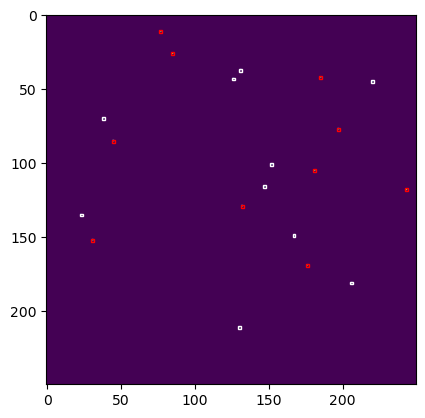

In [3]:
mu_wood = 1.220
mu_iron = 449.45
mu_bis = 1265.54

radius_log = 25 * 5
radius_bullet = [0] * 10

im = generate_image(radius_log, radius_bullet, mu_wood, mu_iron, mu_bis)

rel_error_iron = 0.5
rel_error_bis = 0.5

(boxes_iron, boxes_bis) = detect_bullets(im, mu_iron, mu_bis, rel_error_iron, rel_error_bis)

fig, ax = plt.subplots()
ax.imshow(im)

for ((x1,y1), (x2,y2), n) in boxes_iron:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='white', facecolor='none'))

for ((x1,y1), (x2,y2), n) in boxes_bis:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='red', facecolor='none'))

print(len(boxes_iron), len(boxes_bis))
plt.show()

<ipython-input-2-2dae27fccf30>:98: RuntimeWarning: divide by zero encountered in divide
  tx = (x - x0theta[j,0])/a
<ipython-input-2-2dae27fccf30>:98: RuntimeWarning: invalid value encountered in divide
  tx = (x - x0theta[j,0])/a


28.826510791064106
27 9


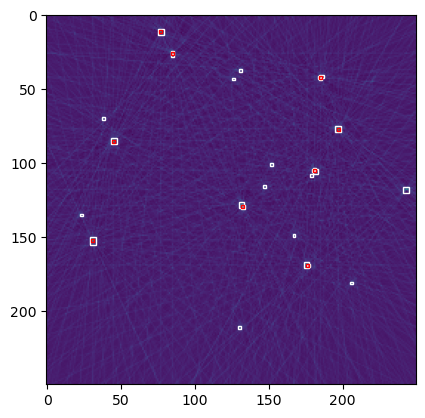

In [4]:
degree = 5
p = 35 * 5
d = 40 * 5
theta = np.arange(0., 180., degree)

N = im.shape[0]
x = im.flatten()
(A, _, _, _) = paralleltomo(N, np.matrix(theta), p, d)
b = A @ x

print(np.linalg.cond(A))

x_rec = np.linalg.lstsq(A, b, rcond=None)[0]
im_rec = x_rec.reshape(N, N)

rel_error_iron = 0.5
rel_error_bis = 0.5
im_scale = mu_bis / np.max(im_rec)

(boxes_iron, boxes_bis) = detect_bullets(im_rec, mu_iron, mu_bis, rel_error_iron, rel_error_bis, im_scale)

fig, ax = plt.subplots()
ax.imshow(im_rec)

for ((x1,y1), (x2,y2), n) in boxes_iron:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='white', facecolor='none'))

for ((x1,y1), (x2,y2), n) in boxes_bis:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='red', facecolor='none'))

print(len(boxes_iron), len(boxes_bis))
plt.show()

<ipython-input-2-2dae27fccf30>:98: RuntimeWarning: divide by zero encountered in divide
  tx = (x - x0theta[j,0])/a
<ipython-input-2-2dae27fccf30>:98: RuntimeWarning: invalid value encountered in divide
  tx = (x - x0theta[j,0])/a


14.111709562312637
34 7


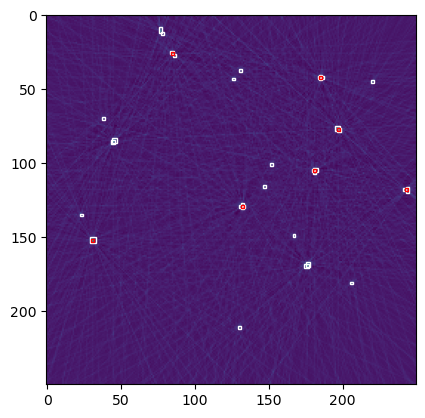

In [5]:
degree = 3
p = 25 * 5
d = 40 * 5
theta = np.arange(0., 180., degree)

N = im.shape[0]
x = im.flatten()
(A, _, _, _) = paralleltomo(N, np.matrix(theta), p, d)
b = A @ x

print(np.linalg.cond(A))

x_rec = np.linalg.lstsq(A, b, rcond=None)[0]
im_rec = x_rec.reshape(N, N)

rel_error_iron = 0.5
rel_error_bis = 0.5
im_scale = mu_bis / np.max(im_rec)

(boxes_iron, boxes_bis) = detect_bullets(im_rec, mu_iron, mu_bis, rel_error_iron, rel_error_bis, im_scale)

fig, ax = plt.subplots()
ax.imshow(im_rec)

for ((x1,y1), (x2,y2), n) in boxes_iron:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='white', facecolor='none'))

for ((x1,y1), (x2,y2), n) in boxes_bis:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='red', facecolor='none'))

print(len(boxes_iron), len(boxes_bis))
plt.show()

In [6]:
degree = 2
p = 65 * 5
d = 55 * 5
theta = np.arange(0., 180., degree)

N = im.shape[0]
x = im.flatten()
(A, _, _, _) = paralleltomo(N, np.matrix(theta), p, d)
b = A @ x

print(np.linalg.cond(A))

x_rec = np.linalg.lstsq(A, b, rcond=None)[0]
im_rec = x_rec.reshape(N, N)

rel_error_iron = 0.5
rel_error_bis = 0.5
im_scale = mu_bis / np.max(im_rec)

(boxes_iron, boxes_bis) = detect_bullets(im_rec, mu_iron, mu_bis, rel_error_iron, rel_error_bis, im_scale)

fig, ax = plt.subplots()
ax.imshow(im_rec)

for ((x1,y1), (x2,y2), n) in boxes_iron:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='white', facecolor='none'))

for ((x1,y1), (x2,y2), n) in boxes_bis:
    ax.add_patch(Rectangle((y1-1, x1-1), y2-y1+2, x2-x1+2, linewidth=1, edgecolor='red', facecolor='none'))

print(len(boxes_iron), len(boxes_bis))
plt.show()

<ipython-input-2-2dae27fccf30>:98: RuntimeWarning: divide by zero encountered in divide
  tx = (x - x0theta[j,0])/a
<ipython-input-2-2dae27fccf30>:98: RuntimeWarning: invalid value encountered in divide
  tx = (x - x0theta[j,0])/a


: 

: 